## softmax 함수

$y_k = \frac{exp(a_k)}{\sum_{i=1}^nexp(a_i)}$

In [ ]:
import numpy as np

a = np.array([0.3, 2.9, 4.0])  # 출력층에서 계산된 3개의 값 - 출력층 뉴런이 3개

# softmax 함수
# 분자 구하기
exp_a = np.exp(a)  # 모든 입력 신호에 대한 지수 함수 적용 (뉴런 각각의 분자 값)
# 분모 구하기
sum_exp_a = np.sum(exp_a)

# 신경망 최종 예측은?
y = exp_a / sum_exp_a
print(y)
print(np.sum(y))  # 1

[0.01821127 0.24519181 0.73659691]
1.0


In [ ]:
# softmax 나쁜 버전 - 오류 상황을 대응할 수 없음
def softmax(a):
  exp_a = np.exp(a)          # 분자 구하기  # 이 부분이 문제
  sum_exp_a = np.sum(exp_a)  # 분모 구하기
  y = exp_a / sum_exp_a

  return y

In [ ]:
a = np.array([1010, 1000, 990])
print(np.exp(a) / np.sum(np.exp(a)))  # softmax 계산

# 지수함수는 지수가 조금만 커져도 값이 엄청 커져버림 -> 컴퓨터에서 계산을 하지 못한다.
# 제곱을 할 수록 값의 편차가 커짐 -> 로그를 씌워서 튜닝!

[nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## 개선된 softmax 구현하기

In [ ]:
c = np.max(a)  # 튜닝을 하기위한 상수 c는 입력값에서 제일 큰 값으로 선정하는 것이 일반적
print(a-c)

[  0 -10 -20]


In [ ]:
# a-c를 softmax 함수에 들어갈 수 있게 한다.
# a-c를 뺀 것은 a+log(c)를 한 것과 같은 효과
print(np.exp(a-c) / np.sum(np.exp(a-c)))

[9.99954600e-01 4.53978686e-05 2.06106005e-09]


In [ ]:
# 튜닝된 softmax
def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c)

  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a

  return y

## 출력층 설계를 위해 필요한 것
- 출력 함수
- 분류 문제라면 출력층의 뉴런 개수 정하기
- = label의 갯수
  - ex) 0~9까지 손글씨 분류 : 10개, 말/고양이/강아지 분류 : 3개

## MNIST 데이터셋

### 데이터셋 로딩

In [ ]:
# tensorflow의 keras를 이용해서 MNIST 불러오기
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# MNIST 데이터셋 로딩
from tensorflow.keras import datasets
mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### shape 확인

어떤 종류의 문제를 풀던 항상 데이터의 shape 부터 확인할 것

In [ ]:
# 데이터의 양 확인
X_train.shape, y_train.shape
# 채널 값 빠져있음 -> 1채널(gray scale)
# 만약 3이면 RGB 이미지
# 가로길이 28, 세로길이 28
# 데이터갯수 60000 (X, y 둘다 6만개 있어야 함 -> 갯수 안 맞으면 훈련 X -> 삭제, 추가 같이 데이터 양의 변화가 있으면 shape 바로 확인해보기)

((60000, 28, 28), (60000,))

### 이미지 시각화

In [ ]:
# 이미지 시각화 해보기 ; 채널 수 필요 없음
image = X_train[0]
image.shape

(28, 28)

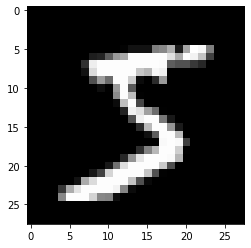

In [ ]:
plt.imshow(image, "gray")
plt.show()

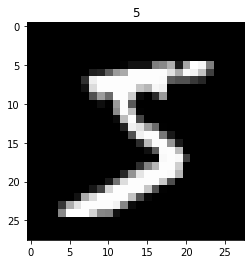

In [ ]:
plt.imshow(image, "gray")
plt.title(y_train[0])
plt.show()
# 0번째 이미지

In [ ]:
# 클래스의 이름을 위에 적어서
# 이미지가 5라는 것 확실히 알 수 있음.

(28, 28)


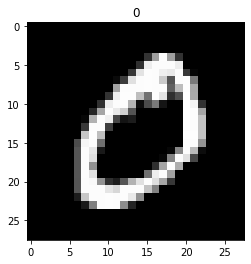

In [ ]:
image1 = X_train[1]
print(image.shape)
plt.imshow(image1, "gray")
plt.title(y_train[1])
plt.show()
# 1번째 이미지

### 신경망에 넣을 준비 - 우리가 준비할 신경망은 Fully Connected Layer

데이터가 1차원 데이터 형식으로 쭉 퍼져 있어야 한다.(flatten)

In [ ]:
image = image.reshape(-1)  # 2차원 데이터 -> 1차원 데이터로 쭉 편다.

In [ ]:
image.shape  # 28x28 데이터가 가로 방향으로 쭉 펴진다.

(784,)

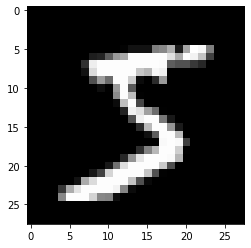

In [ ]:
# 복구
image_bokgu = image.reshape(28, 28)
plt.imshow(image_bokgu, "gray")
plt.show()
# 복구했을 때 제대로 나오는 지 확인

### MNIST 신경망 만들기 - Fully Connected 방식

In [ ]:
# 활성화 함수 구현 (sigmoid)
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# 테스트 데이터 가져오기
def get_test_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  
  image_size = X_test.shape[0]
  X_test_reshaped = X_test.reshape(image_size, -1)

  return X_test_reshaped, y_test

# 훈련된 신경망 가져오기
def init_network():
  import pickle
  with open("./sample_weight.pkl", "rb") as f:
    network = pickle.load(f)
  
  return network

# 예측 함수 만들기
def predict(network, x):
  W1, W2, W3 = network["W1"], network["W2"], network["W3"]
  b1, b2, b3 = network["b1"], network["b2"], network["b3"]
  
  # 구현시에 나는 대부분의 오류 -> 데이터의 형상(shape) 때문이다.
  # 1. 각 층은 입력되는 값과 해당층의 가중치를 곱하고 편향을 더한다.
  # 2. (1)에 의해서 계산된 값에 각 층의 활성화 함수를 씌워주고 다음 층으로 넘긴다.

  # Layer1 계산 (입력 : x)
  z1 = np.dot(x, W1) + b1
  a1 = sigmoid(z1)

  # Layer2 계산 (입력 : a1)
  z2 = np.dot(a1, W2) + b2
  a2 = sigmoid(z2)
  
  # Layer3 계산 (입력 : a2) - 출력층 -> 활성화 함수 : softmax 사용
  z3 = np.dot(a2, W3) + b3
  y = softmax(z3)

  return y 

In [ ]:
network = init_network()
W1, W2, W3 = network["W1"], network["W2"], network["W3"]
b1, b2, b3 = network["b1"], network["b2"], network["b3"]
W1.shape, W2.shape, W3.shape
# 1층, 2층, 출력층에 대한 계산

((784, 50), (50, 100), (100, 10))

In [ ]:
X, y = get_test_data()
network = init_network()
predict(network, X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


array([[1.8234797e-09, 1.9446925e-10, 7.8615081e-08, ..., 4.2491962e-04,
        1.6188409e-10, 2.2574163e-07],
       [8.7074454e-09, 2.7697233e-08, 2.3823570e-05, ..., 6.4393625e-12,
        6.9177473e-09, 9.9881658e-14],
       [5.5241774e-15, 3.9871162e-04, 5.1740553e-08, ..., 1.2315287e-09,
        4.5896982e-08, 1.4465407e-10],
       ...,
       [1.6297103e-12, 1.6991959e-10, 5.6854987e-10, ..., 2.0621649e-09,
        3.1935642e-08, 2.0217622e-07],
       [1.8567052e-09, 6.5277250e-10, 2.1762084e-10, ..., 5.7270719e-11,
        1.6993347e-06, 4.6346812e-10],
       [8.4324245e-09, 8.2065937e-11, 5.0769955e-08, ..., 1.5053431e-11,
        1.1685454e-10, 4.1043047e-11]], dtype=float32)

### 예측과 정확도 보기

In [ ]:
X, y = get_test_data()
network = init_network()
accuracy_count = 0  # 맞춘 갯수를 저장 (정답을 맞추면 1 증가)

# 사진을 한 장씩 꺼내기
for i in range(len(X)):
  pred = predict(network, X[i])
  pred = np.argmax(pred)  # 확률이 가장 높은 원소의 인덱스

  if pred == y[i]:
    accuracy_count += 1
  
print(float(accuracy_count) / len(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


0.9207


위처럼 했을 때의 단점 : 10000장을 한장씩 검사하고 있다.

In [ ]:
X, y = get_test_data()

network = init_network()

# 배치란? 데이터의 묶음이다.
# batch_size : 1 배치당 들어있어야 하는 데이터의 갯수
# ex) 60000개의 데이터를 batch_size 100으로 묶으면 600개의 배치 데이터가 생긴다.

# 참고로 배치를 활용해 60000개의 데이터를 모두 학습시켰으면, 1 에폭(epoch)이라고 한다.

batch_size = 100
accuracy_cnt = 0

for i in range(0, len(X), batch_size):
  X_batch = X[i : i + batch_size] # 순서대로 100개씩 데이터를 쪼갬
  y_batch = predict(network, X_batch) # 데이터를 100개씩 예측

  p = np.argmax(y_batch, axis=1) # 100개의 예측 데이터에서 가장 높은 값의 인덱스를 추출
  accuracy_cnt += np.sum( p == y[i : i + batch_size]) # 100개씩 정답의 합을 구함

print(float(accuracy_cnt) / len(X))

0.9207


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


np.argmax의 axis가 1인 이유
- softmax의 결과는 10개의 원소(결과물)를 가진 1차원 배열
- 이 결과물이 100개씩 묶음 지어져 있다.(배치)
- np.argmax의 axis를 1로 줘야만 각 행별로 최대값의 인덱스를 구한다.